In [32]:
#importing necessary libraries
import tensorflow as tf  #building deep learning models
from tensorflow.keras.datasets import cifar10  #cifar-10 dataset
from tensorflow.keras.utils import to_categorical  #utility for one-hot encoding labels
from tensorflow.keras.preprocessing.image import ImageDataGenerator  #data augmentation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  #visualizing data and results
import numpy as np  #numerical operations and arrays
import cv2  #image processing
from tensorflow.keras.preprocessing.image import load_img, img_to_array  #load and convert images to arrays
from sklearn.utils.class_weight import compute_class_weight  #compute class weights
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
#build the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input

In [3]:
#load and preprocess dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data() #load cifar-10 dataset

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
#normalize pixel values to range 0 - 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
#greyscaling
x_train_gray = np.array([cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) for img in x_train])  #convert RGB images to grayscale format
x_test_gray = np.array([cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) for img in x_test])

In [6]:
#histogram normalization for contrast adjustment
x_train_hist = np.array([cv2.equalizeHist(img) / 255.0 for img in x_train_gray]) #normalize pixel values to range 0-1
x_test_hist = np.array([cv2.equalizeHist(img) / 255.0 for img in x_test_gray])

In [7]:
#add channel dimension back (grayscale images)
x_train_hist = x_train_hist[..., np.newaxis]
x_test_hist = x_test_hist[..., np.newaxis]

In [8]:
#data augmentation for training set
datagen = ImageDataGenerator( #initialize data augmentation generator
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

#prepare the generator
datagen.fit(x_train_hist)

In [9]:
#ensure cifar-10 labels are one-hot encoded
y_train = to_categorical(y_train, num_classes=10) #convert labels to one-hot encoded format
y_test = to_categorical(y_test, num_classes=10)

In [10]:
#process custom images
custom_image_paths = [
    "/content/airplane.jpeg", "/content/automobile.jpeg",
    "/content/bird.jpeg", "/content/cat.jpeg",
    "/content/deer.jpeg", "/content/dog.jpeg",
    "/content/frog.jpeg", "/content/horse.jpeg",
    "/content/ship.jpeg", "/content/truck.jpeg"
]

In [11]:
#corresponding class indices for custom images
custom_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [12]:
#initialize arrays to store custom data
custom_images = []
custom_image_labels = []

for img_path, label in zip(custom_image_paths, custom_labels):
    img = load_img(img_path, target_size=(32, 32), color_mode="grayscale")  #resize and convert to grayscale
    img_array = img_to_array(img) / 255.0  #normalize to 0-1
    custom_images.append(img_array) #add an element to a list
    custom_image_labels.append(label)

In [13]:
#convert to NumPy arrays with correct shapes
custom_images = np.array(custom_images).reshape(-1, 32, 32, 1)  #ensure correct shape for grayscale images
custom_image_labels = to_categorical(np.array(custom_image_labels), num_classes=10)  #one-hot encode labels

In [14]:
#compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(10),
    y=np.argmax(y_train, axis=1)  #convert one-hot labels to class indices
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weights)

Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}


In [16]:
print(f"x_train_hist shape: {x_train_hist.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"custom_images shape: {custom_images.shape}")
print(f"custom_image_labels shape: {custom_image_labels.shape}")


x_train_hist shape: (50000, 32, 32, 1)
y_train shape: (50000, 10)
custom_images shape: (10, 32, 32, 1)
custom_image_labels shape: (10, 10)


In [17]:
#split dataset into train and validation sets using randomization
val_split = 0.2
x_train, x_val, y_train, y_val = train_test_split(
    x_train_hist, y_train, test_size=val_split, random_state=42
)

In [18]:
#verify shapes of x_train and y_train
print(f"x_train before appending custom images: {x_train.shape}")
print(f"y_train before appending custom images: {y_train.shape}")
print(f"custom_images shape: {custom_images.shape}")
print(f"custom_image_labels shape: {custom_image_labels.shape}")

#append custom images and labels to training data
x_train = np.concatenate((x_train, custom_images), axis=0)
y_train = np.concatenate((y_train, custom_image_labels), axis=0)

#verify shapes after concatenation
print(f"x_train after appending custom images: {x_train.shape}")
print(f"y_train after appending custom images: {y_train.shape}")


x_train before appending custom images: (40000, 32, 32, 1)
y_train before appending custom images: (40000, 10)
custom_images shape: (10, 32, 32, 1)
custom_image_labels shape: (10, 10)
x_train after appending custom images: (40010, 32, 32, 1)
y_train after appending custom images: (40010, 10)


In [19]:
#custom CNN model for grayscale input
def build_custom_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 1))
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs) #define a layer in the neural network
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x) #increased dropout rate
    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [25]:
#learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

In [21]:
#augmentation to improve generalization
datagen = ImageDataGenerator( #initialize data augmentation generator
    width_shift_range=0.1, #apply random horizontal shifts
    height_shift_range=0.1, #apply random vertical shifts
    horizontal_flip=True #apply horizontal flips
)
datagen.fit(x_train) #train the model with training data #train the model using augmented data

In [27]:
#build the model
model = build_custom_model()

#train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),  #use the updated x_train with appended custom images
    validation_data=(x_val, y_val),  #validation data remains unaugmented
    epochs=50,
    class_weight=class_weights,
    callbacks=[lr_callback]  #include learning rate scheduler callback
)

Epoch 1/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.2743 - loss: 1.9820 - val_accuracy: 0.4915 - val_loss: 1.4757 - learning_rate: 0.0010
Epoch 2/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.4644 - loss: 1.5227 - val_accuracy: 0.5532 - val_loss: 1.2815 - learning_rate: 0.0010
Epoch 3/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5212 - loss: 1.3748 - val_accuracy: 0.6058 - val_loss: 1.1293 - learning_rate: 0.0010
Epoch 4/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5389 - loss: 1.3130 - val_accuracy: 0.6076 - val_loss: 1.1145 - learning_rate: 0.0010
Epoch 5/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5657 - loss: 1.2573 - val_accuracy: 0.6288 - val_loss: 1.0538 - learning_rate: 0.0010
Epoch 6/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5825 - loss: 1.2042 - val_accuracy: 0.6317 - val_loss: 1.0742 - learning_rate: 0.0010
Epoch 7/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.5876 - l

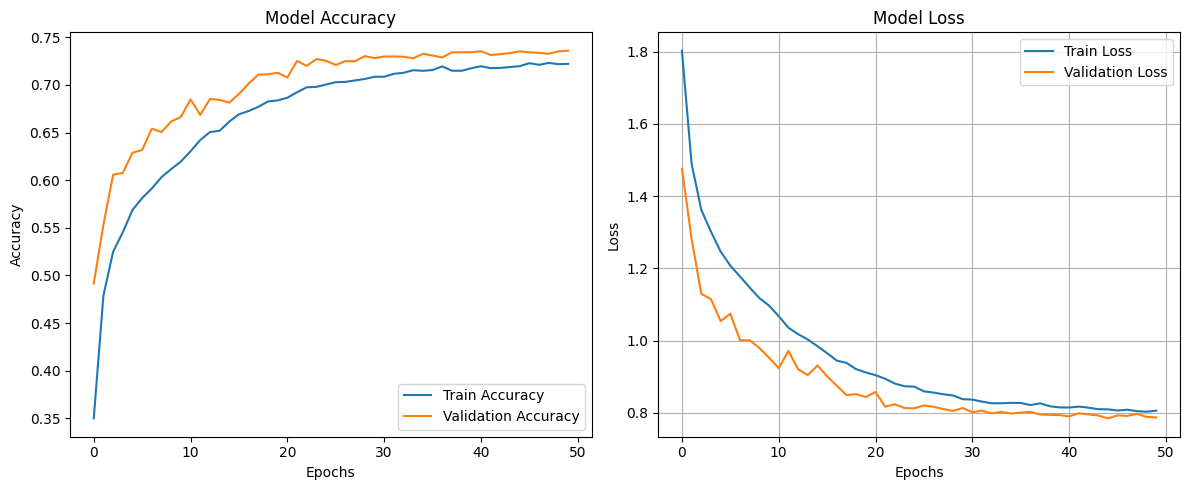

In [28]:
#visualize accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy') #plot the graph
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [39]:
#evaluate the model
loss, accuracy = model.evaluate(x_test_hist, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7356 - loss: 0.7864


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


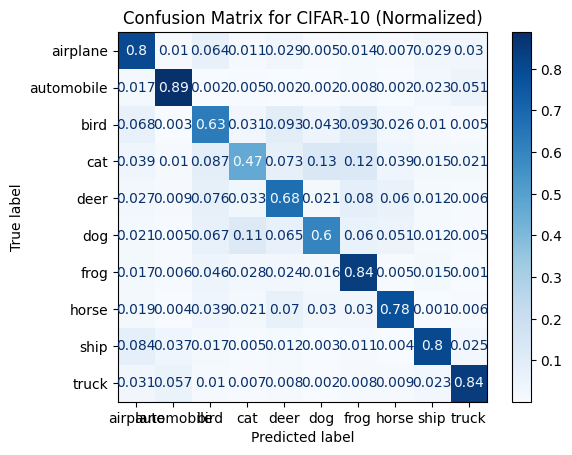

Classification Report:
              precision    recall  f1-score   support

    airplane       0.71      0.80      0.75      1000
  automobile       0.86      0.89      0.88      1000
        bird       0.61      0.63      0.62      1000
         cat       0.65      0.47      0.54      1000
        deer       0.64      0.68      0.66      1000
         dog       0.71      0.60      0.65      1000
        frog       0.66      0.84      0.74      1000
       horse       0.79      0.78      0.79      1000
        ship       0.85      0.80      0.83      1000
       truck       0.85      0.84      0.85      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



In [33]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#re-use preprocessed grayscale test data
x_test_gray = x_test_hist  #use preprocessed test data (grayscale and histogram equalized)

#generate predictions on test set
y_pred = model.predict(x_test_gray)

#convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

#compute and normalize confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, normalize='true')

#display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CIFAR-10 (Normalized)')
plt.show()

#print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=cifar10_classes))

In [38]:
#predict unseen images
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def predict_unseen_image(model, image_path):
    img = load_img(image_path, target_size=(32, 32), color_mode="grayscale")
    img_array = img_to_array(img) / 255.0 #normalize pixel values to 0 - 1
    img_array = np.expand_dims(img_array, axis=0)  #add batch dimension
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    print(f"Predicted class: {class_labels[class_idx]} ({prediction[0][class_idx] * 100:.2f}% confidence)")

#predictions
predict_unseen_image(model, "/content/airplane.jpeg")
predict_unseen_image(model, "/content/automobile.jpeg")
predict_unseen_image(model, "/content/bird.jpeg")
predict_unseen_image(model, "/content/cat.jpeg")
predict_unseen_image(model, "/content/deer.jpeg")
predict_unseen_image(model, "/content/dog.jpeg")
predict_unseen_image(model, "/content/frog.jpeg")
predict_unseen_image(model, "/content/horse.jpeg")
predict_unseen_image(model, "/content/ship.jpeg")
predict_unseen_image(model, "/content/truck.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: airplane (91.29% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted class: automobile (99.57% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: bird (88.65% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted class: dog (47.15% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: deer (72.75% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: deer (36.65% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: bird (38.06% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: horse (73.82% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: airplane (43.56% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: truck (52.91% confidence)
